In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numpy import exp as exp
from mpl_toolkits import mplot3d
import pandas as pd
from scipy.optimize import curve_fit
from itertools import product
from scipy.integrate import solve_ivp
import scienceplots

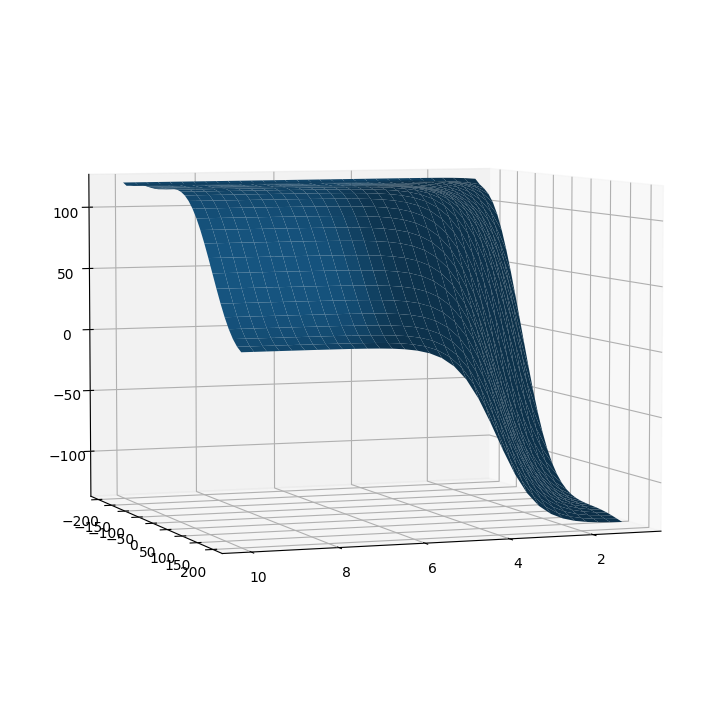

In [2]:
# @jit
def J_v(pH_L, psi):
    
    psi_start, psi_end = -300, 300
    pH_start, pH_end = 0, 9
    
    if (pH_L < pH_start):
        pH_L = pH_start
    elif (pH_L > pH_end):
        pH_L = pH_end
    
    if (psi < psi_start):
        psi = psi_start
    elif (psi > psi_end):
        psi = psi_end
    
    p_a = 3.3654e-24*psi**10+-1.72718633e-21*psi**9+-1.88006118e-19*psi**8+1.84428806e-16*psi**7+1.14875767e-15*psi**6+-7.86180209e-12*psi**5+8.73621142e-11*psi**4+1.38612359e-07*psi**3+4.02706504e-06*psi**2+-0.000921991562*psi**1+0.892742811*psi**0
    p_b = -0.01183303*psi**1+-1.74410965*psi**0
    p_c = 1.97927106e-17*psi**8+-8.11163955e-15*psi**7+-1.41331765e-12*psi**6+7.37414295e-10*psi**5+2.69242151e-08*psi**4+-1.47727446e-05*psi**3+-0.0018809272*psi**2+0.0294192901*psi**1+122.27226*psi**0
    p_d = 3.32575786e-13*psi**6+-3.43339599e-11*psi**5+-5.76545216e-08*psi**4+7.89631331e-06*psi**3+0.00138326473*psi**2+0.11950506*psi**1+1.50734239*psi**0
    
    
    J = np.tanh(p_a*pH_L + p_b)*p_c-p_d
    return J

x = np.outer(np.linspace(1, 10, 32), np.ones(32))
y = np.outer(np.linspace(-200, 200, 32), np.ones(32)).T
z = np.vectorize(J_v)(x, y)
 
# Creating figure
fig = plt.figure(figsize = (14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
ax.plot_surface(x, y, z)
ax.view_init(5, 70)

# show plot
plt.show()

In [4]:
init_R = 0.34                     	           #organelle radius [microns]
init_V = (4/3*3.1416*init_R**3*1e-12)/1000
init_S = 4*3.1416*init_R**2*1e-8
#{surface area [cm**2]}


# B = 0.08095428   # Donnan particles concentration [M]

CAX_Ca = 1       # Calcium stoichiometry of CAX
CAX_H = 3        # Proton stoichiometry of CAX 
CLC_Cl = 2       # Chloride stoichiometry of ClC-7
CLC_H = 1        # Proton stoichiometry of ClC-7
Ca_C = 1e-07      #[M]
Cl_C = 0.05      #[M]
Na_C = 0.015      #[M]
F = 96485      #[C] Na*e
K_C = 0.145      #[M]
NA = 6.02e+23    
NCX_Ca = 3       #[]
NCX_Na = 1       #[]
NHE_H = 1       #[]
NHE_Na = 1       #[]
N_CAX = 10       #[]
N_CLC = 50      #[]
N_NCX = 0       #[]
N_NHE = 0       #[]
N_VATP = 300 #!!      #[]


N_VATP = 300      #[]
incr_coeff = 3.0
P_Ca = 1.49e-7       #[ion*cm/s]
P_Cl = 1.2e-5       #[ion*cm/s]
P_H = 6e-05      #[ion*cm/s]
P_K = 7.1e-7      #[ion*cm/s]
P_Na = 9.6e-7      #[ion*cm/s]
# R = 0.34           #[mcm]
RTF = 25.69        #RT/F [mV]} ??????????????????????????????????????
# S = (1.45267584e-08)*(incr_coeff**2 )     #[cm^2]
ans = 0.25      #[]
beta_pH = 0.04      #[M/pH] Proton buffering capacity
cap = 1.45267584e-14      #[Farad] -  тут в оригинале -17, и в беркле тоже, это странно
cap_0 = 1e-06      #[F/cm^2] Bilayer capacitance 
init_Aeff = 0.3      
init_Ca_F = 0.0006      #[M]
init_Ca_T = 0.006      #[M]
init_Cl = 0.06      #[M]
init_H = 1e-5      #[M]
init_K = 0.04      #[M]
init_Na = 0.09      #[M]

psi_in = 0       #[mV]
psi_out = -50  
B = init_K+init_Na+init_H-init_Cl - cap/F/init_V*(psi_in - psi_out)
# init_V = 1.64636595e-16      #[L]
# init_pH = 4.5     
init_pH = 4.8     
init_psi_total = 0       #[mV]
p = 3.88e-9       
pH_C = 7.2     
    #[mV] 
q = 2.2
r = 0.1      #Deactivation to activation ratio 
tau_act = 1       #[s]
tau_deact = 0.25      #[s]
N_NsXer = 1000      


Pw = 0.054e-2 #water permeability
Oc = 0.291
oh =  0.73
ok =  0.73
ona = 0.73
ocl = 0.73
Q = init_V*(Oc - (oh*10**(-init_pH) + ok*init_K + ona*init_Na + ocl*init_Cl))

In [5]:
# @jit
def derivatives(X, t):
    
    '''
    compute derivatives of X wrt time
    '''
    Aeff, NH, pH, NK, NNa, NCl, NCa_T, NCa_F, R = X
    
    V = (4/3*3.1416*abs(R)**3*1e-12)/1000
    S = 4*3.1416*abs(R)**2*1e-8

            
    #Luminal Concentrations
    H = NH/V/NA
    K = NK/V/NA
    Na = NNa/V/NA
    Cl = NCl/V/NA
    Ca_F = NCa_F/V/NA
    Ca_T = NCa_T/V/NA
    r = 0.1
    
    #membrane potential
#     psi = (F/cap)*init_V*(H + K + Na - Cl + 2*Ca_T - B)
    psi = (F/cap)*(V*(H + K + Na - Cl + 2*Ca_T) - B*init_V)


#      Modified Cytoplasmic Surface Concentrations
    pH_C0   = (pH_C+psi_out/(RTF*2.3))
    K_C0    = K_C*exp(-psi_out/RTF)
    Na_C0   = Na_C*exp(-psi_out/RTF) 
    Cl_C0   = Cl_C*exp(psi_out/RTF) 
    Ca_F_C0 = Ca_C*exp(-2*psi_out/RTF) 
    
#     Modified Luminal Surface Concentrations
    pH_L0   = (pH+psi_in/(RTF*2.3))
    K_L0    = K*exp(-psi_in/RTF)
    Na_L0   = Na*exp(-psi_in/RTF) 
    Cl_L0   = Cl*exp(psi_in/RTF) 
    Ca_F_L0 = Ca_F*exp(-2*psi_in/RTF) 

    delta_pH    = pH_C0-pH_L0;  

#     Treatment of singular terms for passive ion flux
    if (abs(psi) > 300):
        psi = np.sign(psi)*300
    if (abs(psi) > 0.01):
        gg      =  psi / (1 - exp (- psi / RTF)) / RTF
        gg_Ca   = 2*psi/(1-exp(-2*psi/RTF))/RTF

    else: 
        gg      =  1 / 1 - (psi / RTF)/2 + (psi / RTF)**2/6 - (psi / RTF)**3 / 24 + (psi / RTF) ** 4 / 120
        gg_Ca   = 1/(1 - (psi/RTF) + (2/3)*(psi/RTF)**2 - (1/3)*(psi/RTF)**3 +(2/15)*(psi/RTF)**4)
        

    J_VATPASE  = N_VATP * J_v(pH, psi)

    


        # ClC-7 Antiporter {H out, Cl in}
    CLC_mu      = (CLC_H + CLC_Cl)*psi + RTF*(CLC_H*2.3*delta_pH + CLC_Cl*np.log(Cl_C0/Cl_L0))
    
    #     Switching function   
    x = 0.5 + 0.5*np.tanh((CLC_mu + 250)/75); 
    # Activity
    A = 0.3*x + 1.5E-5*(1-x)*CLC_mu**2;
    
    if (A < Aeff):
        tau = tau_deact
    else:
        tau = tau_act
        
    J_CLC    = N_CLC*Aeff*CLC_mu 
    
    
#      CAX Antiporter {H out, Ca in} [mV, ion/s]
    CAX_mu = (CAX_H - 2*CAX_Ca)*psi + RTF*(CAX_H*2.3*delta_pH + CAX_Ca/2*np.log(Ca_F_L0/Ca_F_C0))
    J_CAX = N_CAX*CAX_mu
    
    

    
#      Passive flux [ion/s]
    J_H = P_H*S*(10**(-pH_C0)*exp(-psi/RTF)-10**(-pH_L0))*gg*NA/1000
#     J_K = P_K*S*(K_C0*exp(-psi/RTF)-K_L0)*gg*NA/1000
#     J_Na = P_Na*S*(Na_C0*exp(-psi/RTF)-Na_L0)*gg*NA/1000

    J_K = P_K*S*((K_C0+Na_C0)*exp(-psi/RTF)-(K_L0+Na_L0))*gg*NA/1000
    J_Na = P_Na*S*((Na_C0+K_C0)*exp(-psi/RTF)-(K_L0+Na_L0))*gg*NA/1000
    J_Cl_unc = P_Cl*S*(Cl_C0-Cl_L0*exp(-psi/RTF))*gg*NA/1000
    J_Ca = P_Ca*S*(Ca_F_C0*exp(-2*psi/RTF)-Ca_F_L0)*gg_Ca*NA/1000
    


    
    #water flux
    J_w = Pw*S*(oh*10**(-pH) + ok*K + ona*Na + ocl*Cl + Q/V - Oc)
    
    
#     TRPML1 channel
    y = 0.5 - 0.5*np.tanh(psi + 40)
    P_trpml1 = (3.88e-12)*(y*abs(psi) + (1-y)*(abs(psi + 40)**3)/(pH**q)) #change p
    J_Ca_trpml1 = -P_trpml1*S*(Ca_F_C0*exp(-2*psi/RTF)-Ca_F_L0)*gg_Ca*NA/1000

    
    
    pure_basefication = int((t>=2000))*2.5e4  
    dxdt = [(1/tau)*(A - Aeff),
        J_H + (J_VATPASE) - (CLC_H*J_CLC) - (CAX_H*J_CAX) - pure_basefication, 
           (-(J_H + (J_VATPASE) - (CLC_H*J_CLC) - (CAX_H*J_CAX) - pure_basefication)/V/NA)/beta_pH,
           J_K,
           J_Na,
           J_Cl_unc + (CLC_Cl*J_CLC),
           J_Ca + (CAX_Ca*J_CAX) - J_Ca_trpml1,
           (J_Ca + (CAX_Ca*J_CAX) - J_Ca_trpml1)*r, 
           J_w/(1000*55)/(4*np.pi*(R/1e5)**2)*1e5]

    return dxdt

In [6]:
init_NH = init_H*init_V*NA;      #[ions]
init_NK = init_K*init_V*NA;       
init_NNa = init_Na*init_V*NA;    
init_NCl = init_Cl*init_V*NA;     
init_NCa_T = init_Ca_T*init_V*NA; 
init_NCa_F = init_Ca_F*init_V*NA; 

X0 = [init_Aeff, init_NH, init_pH, init_NK, init_NNa, init_NCl, init_NCa_T, init_NCa_F, init_R]

In [7]:
tspan = np.arange(0, 5000, 1e-2)
solution = odeint(derivatives, X0, tspan)

3505.02927442466
3505.025244308585
3505.0252443225213
3505.0212142238984
3505.0212142378323
3501.0113898228465
3501.011378682661
3497.0188226750765
3497.0188004394513
3493.043419787906
3493.0433976316594
3475.4268718239473
3475.4266916585434
3480.3374719193635
3480.337377639247
3467.8063669715652
3467.806468160307
3470.082381810877
3470.0824430248013
3459.9430514885216
3459.943047864701
3449.917757083288
3449.917759460569
3440.005162358365
3440.005164721275
3420.512491075035
3420.512502304291
3401.454149983155
3401.454144054763
3382.819480241342
3382.8194743104173
3364.598165254581
3364.5981649676355
3346.780169864852
3346.7801695562075
3286.8223970263953
3286.8223790852935
3231.3885635359325
3231.3885372109053
3180.1082787943283
3180.1083125607897
3197.441275494336
3197.441284997153
3224.4604815931275
3224.4604817660056
3217.602496403269
3217.6024959706356
3210.813807835092
3210.8138081977536
3204.093655939651
3204.093655839483
3197.441285583384
3197.4412855821615
3190.85595331899
319

In [8]:
tspan_stat = np.arange(0, 20000, 1e-2)
solution_stat = odeint(derivatives, X0, tspan_stat)

3505.02927442466
3505.025244308585
3505.0252443225213
3505.0212142238984
3505.0212142378323
3501.0113898228465
3501.011378682661
3497.0188226750765
3497.0188004394513
3493.043419787906
3493.0433976316594
3475.4268718239473
3475.4266916585434
3480.3374719193635
3480.337377639247
3467.8063669715652
3467.806468160307
3470.082381810877
3470.0824430248013
3459.9430514885216
3459.943047864701
3449.917757083288
3449.917759460569
3440.005162358365
3440.005164721275
3420.512491075035
3420.512502304291
3401.454149983155
3401.454144054763
3382.819480241342
3382.8194743104173
3364.598165254581
3364.5981649676355
3346.780169864852
3346.7801695562075
3286.8223970263953
3286.8223790852935
3231.3885635359325
3231.3885372109053
3180.1082787943283
3180.1083125607897
3197.441275494336
3197.441284997153
3224.4604815931275
3224.4604817660056
3217.602496403269
3217.6024959706356
3210.813807835092
3210.8138081977536
3204.093655939651
3204.093655839483
3197.441285583384
3197.4412855821615
3190.85595331899
319

In [9]:
def V_arr_def(solution):
    V_arr = (4/3*3.1416*solution[:, 8]**3*1e-12)/1000
    return V_arr

def Psi_arr_def(solution, V_arr):
    psi_arr = (F/cap)*(V_arr*(solution[:, 1]/V_arr/NA + solution[:, 3]/V_arr/NA + solution[:, 4]/V_arr/NA - solution[:, 5]/V_arr/NA + 2*solution[:, 6]/V_arr/NA) - B*init_V)
    return psi_arr
    
def J_w_arr_def(solution, V_arr):
    J_w_arr = Pw*4*3.1416*abs(solution[:, 8])**2*1e-8*(oh*10**(-solution[:, 2]) + ok*solution[:, 3]/V_arr/NA + ona*solution[:, 4]/V_arr/NA + ocl*solution[:, 5]/V_arr/NA + Q/V_arr - Oc)
    return J_w_arr

In [10]:
V_arr = V_arr_def(solution)
psi_arr = Psi_arr_def(solution, V_arr)
J_w_arr = J_w_arr_def(solution, V_arr)

V_arr_stat = V_arr_def(solution_stat)
psi_arr_stat = Psi_arr_def(solution_stat, V_arr_stat)
J_w_arr_stat = J_w_arr_def(solution_stat, V_arr_stat)


In [11]:
def set_plot_font_params():
    """
    Set the font parameters for all plots in the Matplotlib instance.
    """
    # Set the font family and style
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Times new roman']
    plt.rcParams['font.style'] = 'normal'

    # Set the font sizes
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['legend.fontsize'] = 20

set_plot_font_params()

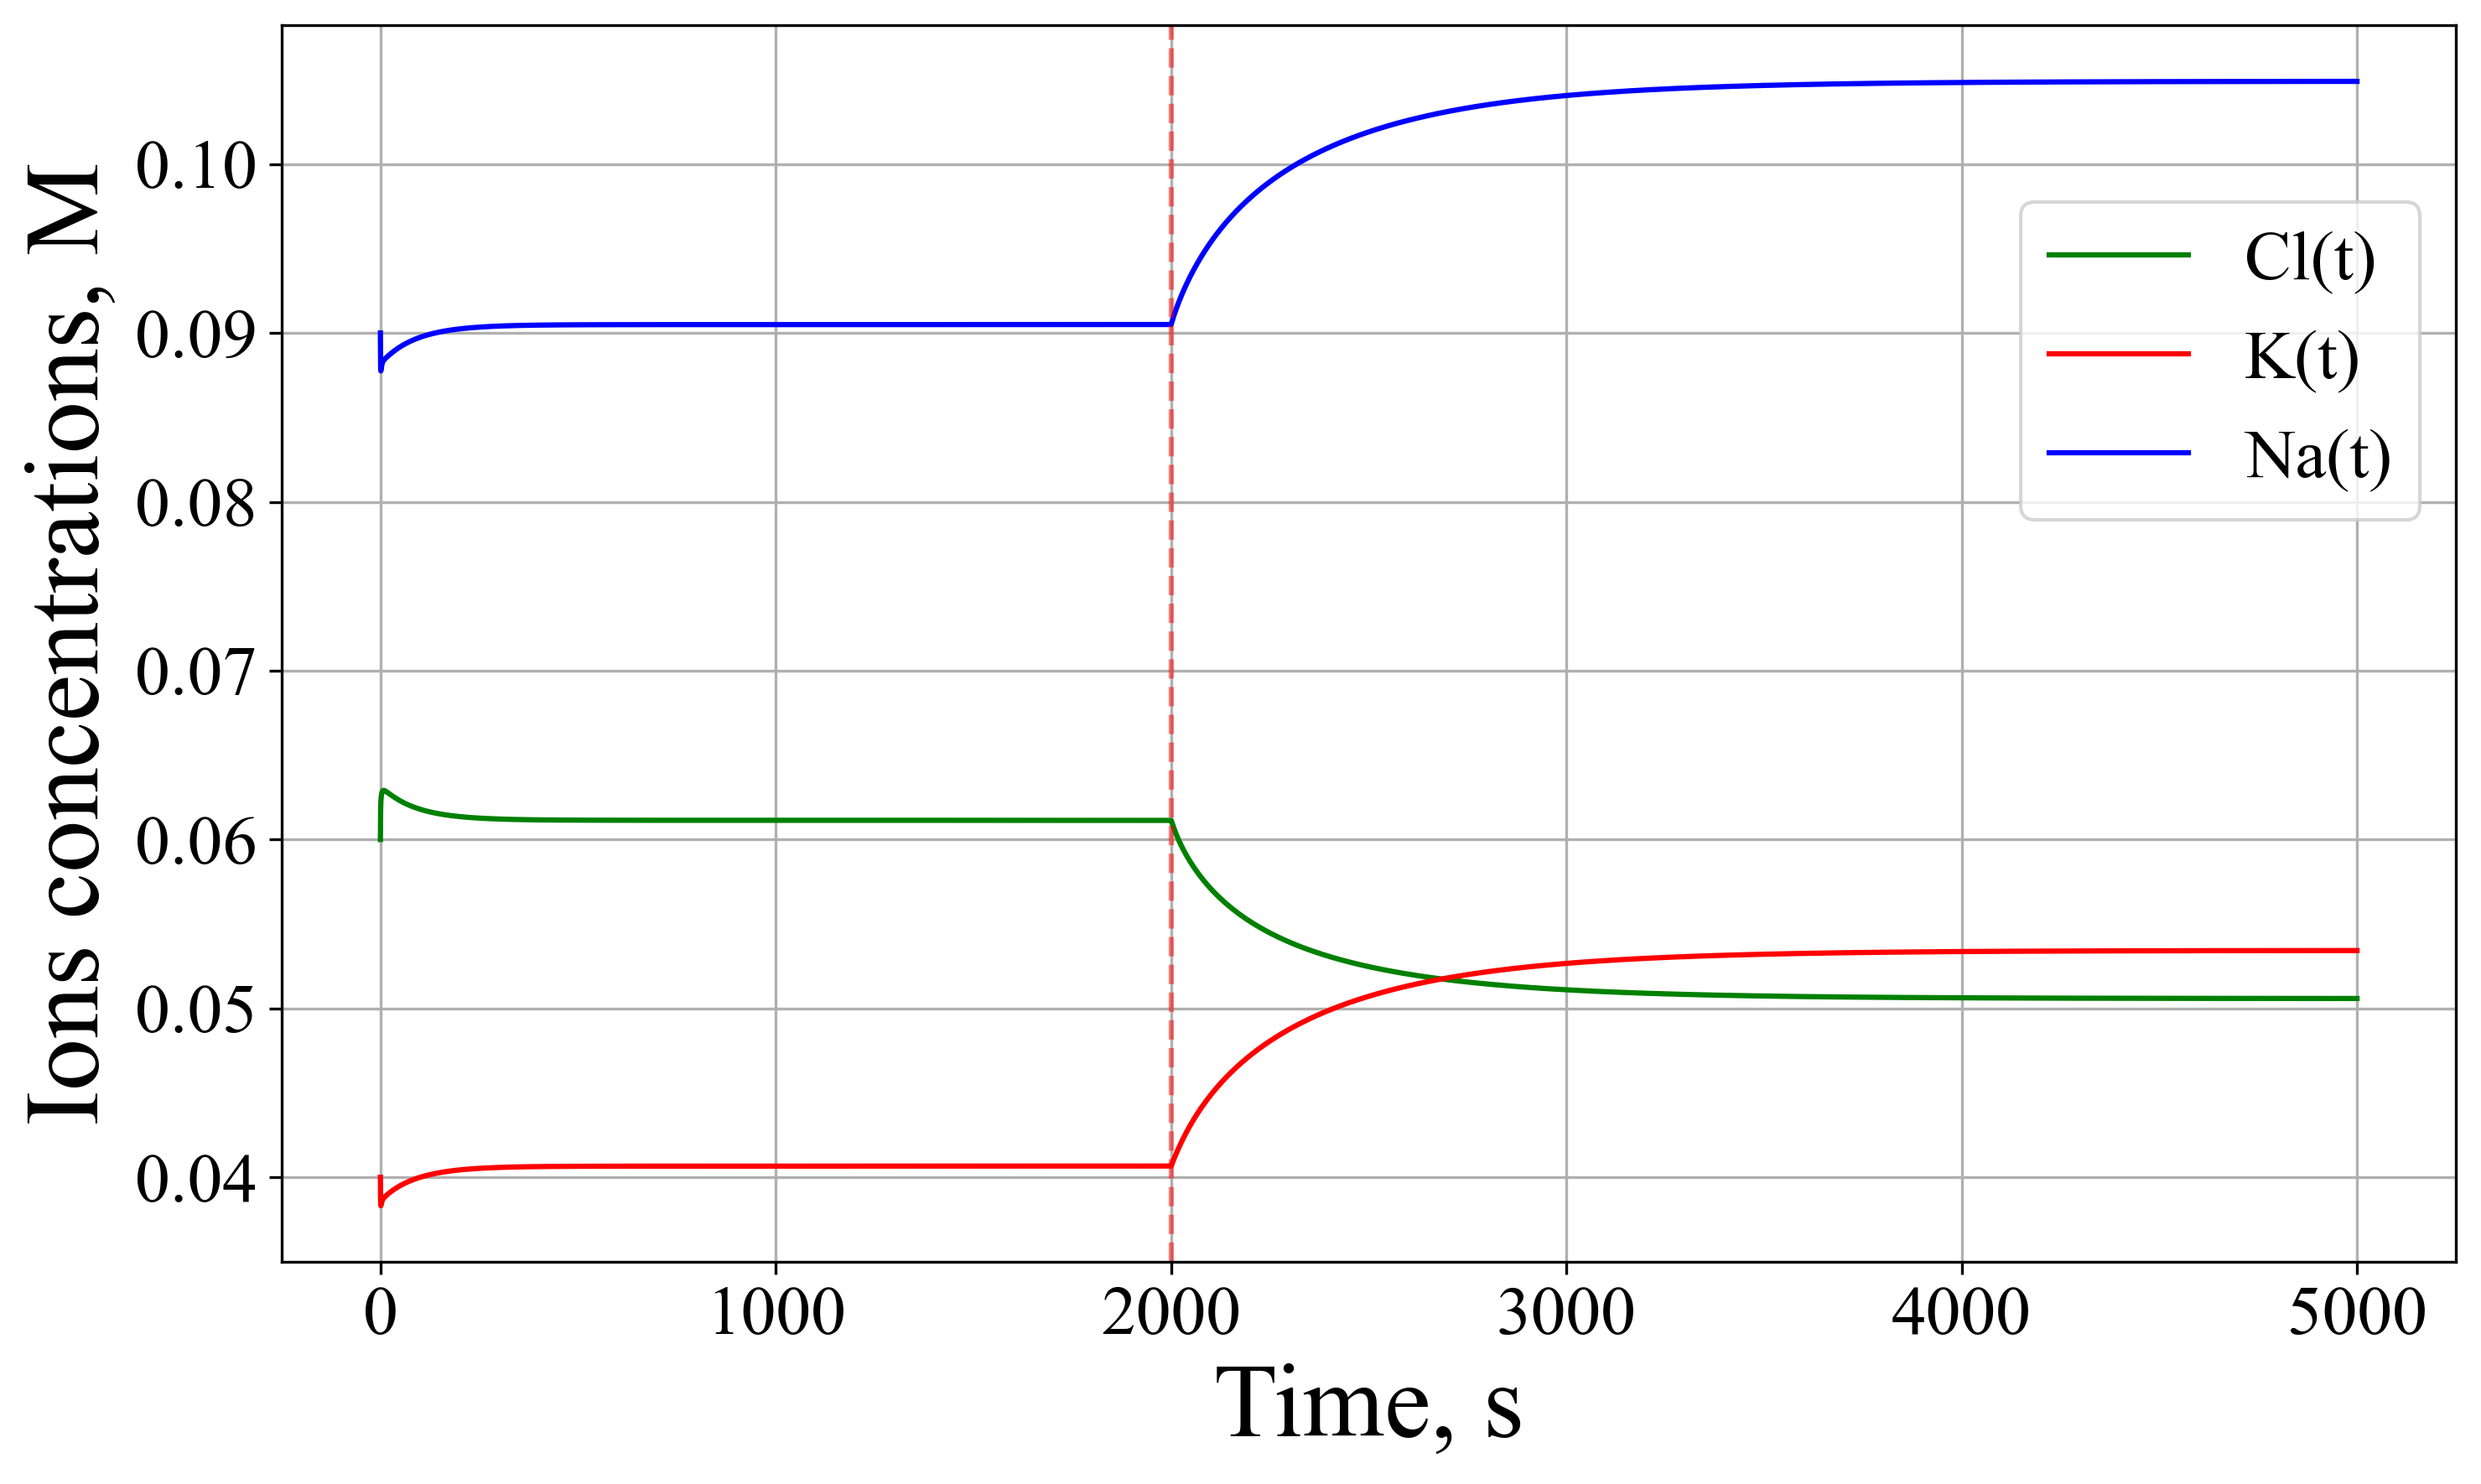

In [12]:
def plot_solution_concentrations(t, solution, V_arr):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

  
    cl_conc = solution[:, 5] / V_arr / NA
    k_conc = solution[:, 3] / V_arr / NA
    na_conc = solution[:, 4] / V_arr / NA

    # Plot the concentrations
    ax.plot(t, cl_conc, 'g', label='Cl(t)')
    ax.plot(t, k_conc, 'r', label='K(t)')
    ax.plot(t, na_conc, 'b', label='Na(t)')

    ax.legend(loc=[0.8, 0.6], fontsize = 20)
    ax.set_ylabel('Ions concentrations, M', fontsize=30)
    ax.set_xlabel('Time, s', fontsize=30)
    ax.tick_params(axis='both', labelsize=20)
    ax.grid()

    plt.tight_layout()

    # Add a vertical dashed line 
    ax.axvline(x=2000, linestyle='--', color='r', alpha=0.5)
    plt.show()

plot_solution_concentrations(tspan, solution, V_arr)


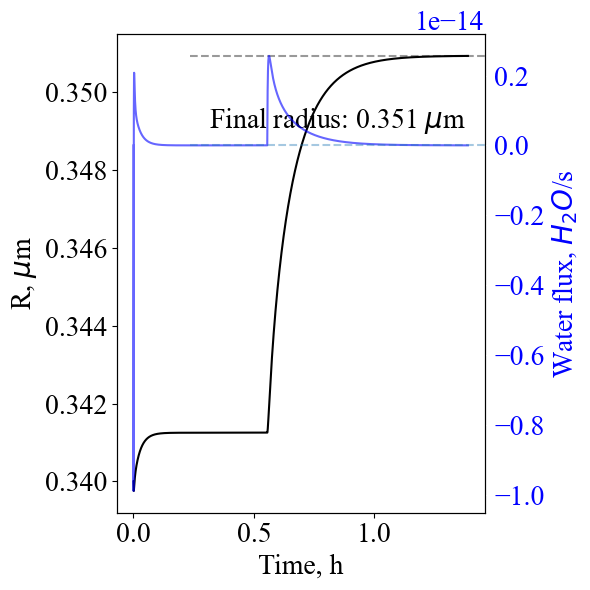

In [13]:
set_plot_font_params()

def plot_solution_R(t, solution, solution_stat, V_arr, V_arr_stat, J_w_arr, J_w_arr_stat):
    
    J_w_arr_stat = J_w_arr_stat[-1]
    fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)
    t = t/3600

    # Plot R(t)
    ax1.plot(t, solution[:, 8], 'black', label='R(t)')
    ax1.set_ylabel(r'R, $\mu$m', fontsize=20, color='black')
    ax1.tick_params(axis='y', colors='black')

    ax1.axhline(solution_stat[:, 8][-1], 0.2, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
    

    ax1.text(0.95, 0.85, 'Final radius: {:.3f} $\mu$m'.format(solution_stat[:, 8][-1]), transform=ax1.transAxes, ha='right', va='top', fontsize=20, color='black')


    # Create a second y-axis for J_w_arr
    ax2 = ax1.twinx()

    # Plot J_w_arr
    ax2.plot(t, J_w_arr, 'b', label='J_w_arr', alpha=0.6)  # Set transparency with alpha
    ax2.set_ylabel(r'Water flux, $H_2O$/s', fontsize=20, color='b')
    ax2.tick_params(axis='y', colors='white', labelcolor='b')
    ax2.axhline(0, 0.2, 1, linestyle = 'dashed', alpha = 0.4)
    

    # Set the x-axis label and tick color
    ax1.set_xlabel('Time, h', fontsize=20)
    ax1.tick_params(axis='x', colors='k')  # Set x-tick color to black

    plt.tight_layout()
    plt.show()



plot_solution_R(tspan, solution, solution_stat, V_arr, V_arr_stat, J_w_arr, J_w_arr_stat)



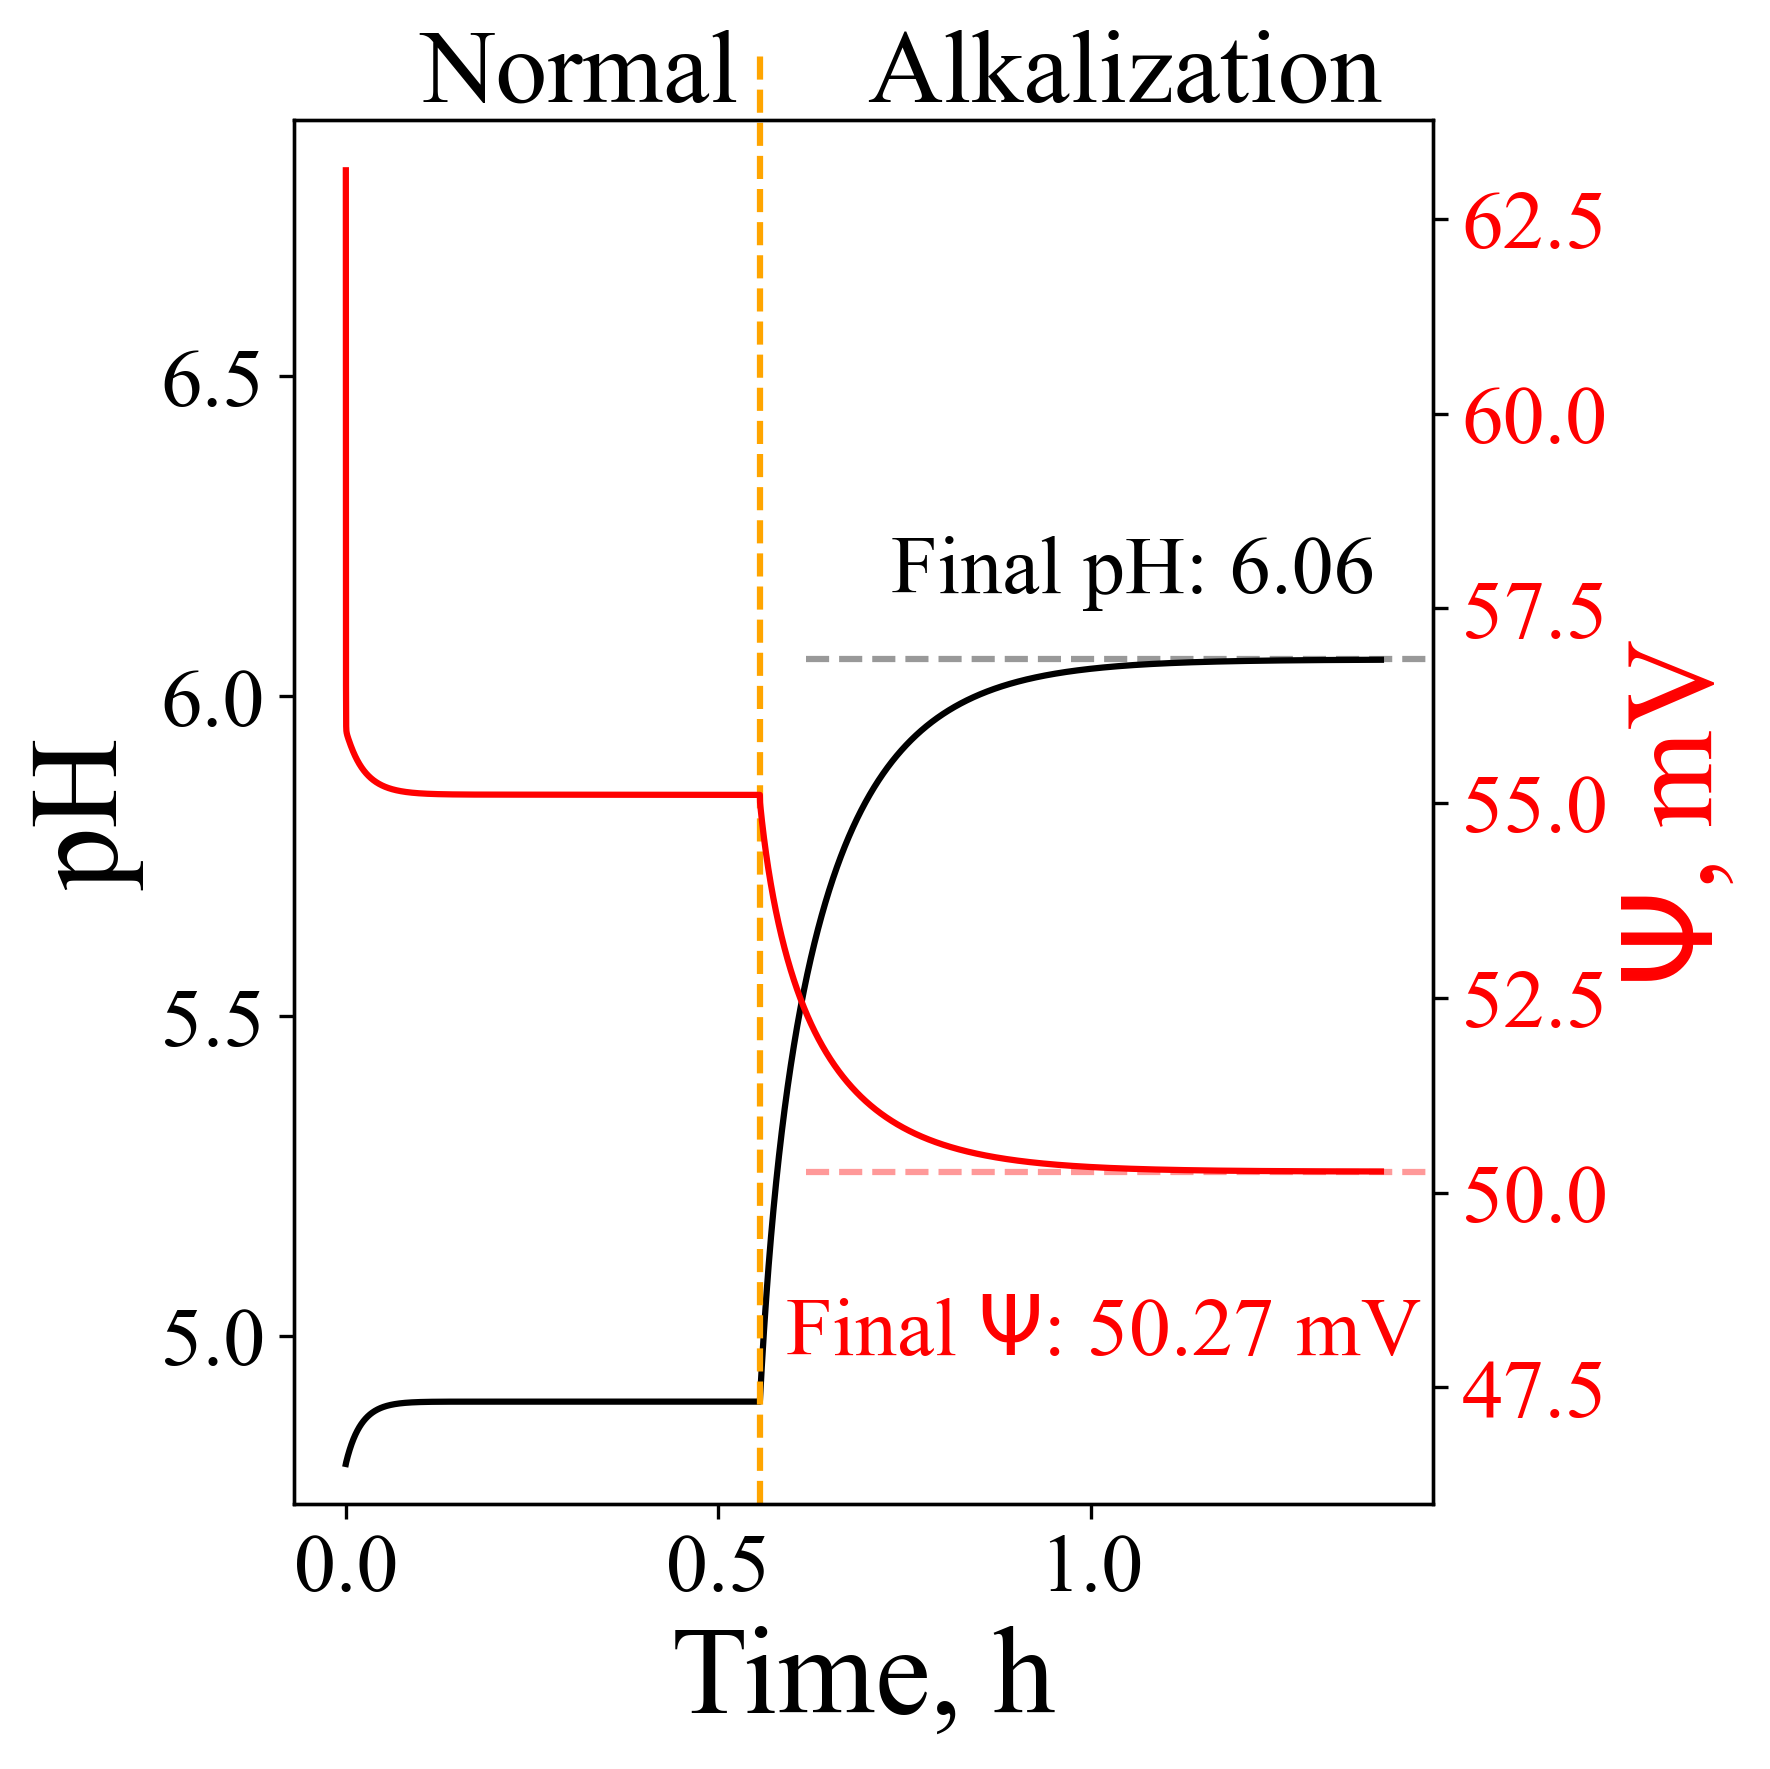

In [20]:
set_plot_font_params()

def plot_solution_pH_psi(t, solution, solution_stat, psi_arr, psi_stat):
    fig, ax1 = plt.subplots(figsize=(6, 6), dpi=300)

    t = t/3600

    # Plot R(t)
    ax1.plot(t, solution[:, 2], 'black', label='pH$(t)$')
    ax1.set_ylabel(r'pH', fontsize=30, color='black')
    ax1.tick_params(axis='y', colors='black')
    ax1.axhline(solution_stat[:, 2][-1], 0.45, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax1.text(0.95, 0.7, 'Final pH: {:.2f}'.format(solution_stat[:, 2][-1]), transform=ax1.transAxes, ha='right', va='top', fontsize=20, color='black')
    ax1.set_ylim(ymax = 6.9)
    # Create a second y-axis for J_w_arr
    ax2 = ax1.twinx()

    # Plot J_w_arr
    psi_arr = (F/cap)*init_V*(solution[:, 1]/init_V/NA + solution[:, 3]/init_V/NA + solution[:, 4]/init_V/NA - solution[:, 5]/init_V/NA + 2*solution[:, 6]/init_V/NA - B)

    ax2.plot(t, psi_arr, 'r', label=r'$\Psi$(t)', alpha=1)  # Set transparency with alpha
    ax2.set_ylabel(r'$\Psi$, mV', fontsize=30, color='r')
    ax2.tick_params(axis='y', colors='black', labelcolor='red')
    ax2.axhline(psi_stat, 0.45, 1, color = 'r', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax2.text(0.99, 0.15, 'Final $\Psi$: {:.2f} mV'.format(psi_stat), transform=ax2.transAxes, ha='right', va='top', fontsize=20, color='r')

    ax2.set_ylim(ymin = 46)
    

    # Set the x-axis label and tick color
    ax1.set_xlabel('Time, h', fontsize=30)
    ax1.tick_params(axis='x', colors='k')  # Set x-tick color to black


    ax1.axvline(2000/3600, 0, 1.05, color = 'orange', clip_on=False, linestyle='dashed', alpha = 1)
    ax1.text(0.7, 6.93, s='Alkalization', fontsize=25, color='black')
    ax1.text(0.1, 6.93, s='Normal', fontsize=25, color='black')
    # ax1.text(0.6, 7.5, s='N vATPase', fontsize=25, color='black')
    #add space between plot and title
    ax1.tick_params(axis='both', labelsize=20)
    ax2.tick_params(axis='both', labelsize=20)
    plt.tight_layout()
    plt.savefig('all_figs/6CAA_pH')
    plt.show()



plot_solution_pH_psi(tspan, solution, solution_stat, psi_arr, psi_arr_stat[-1])


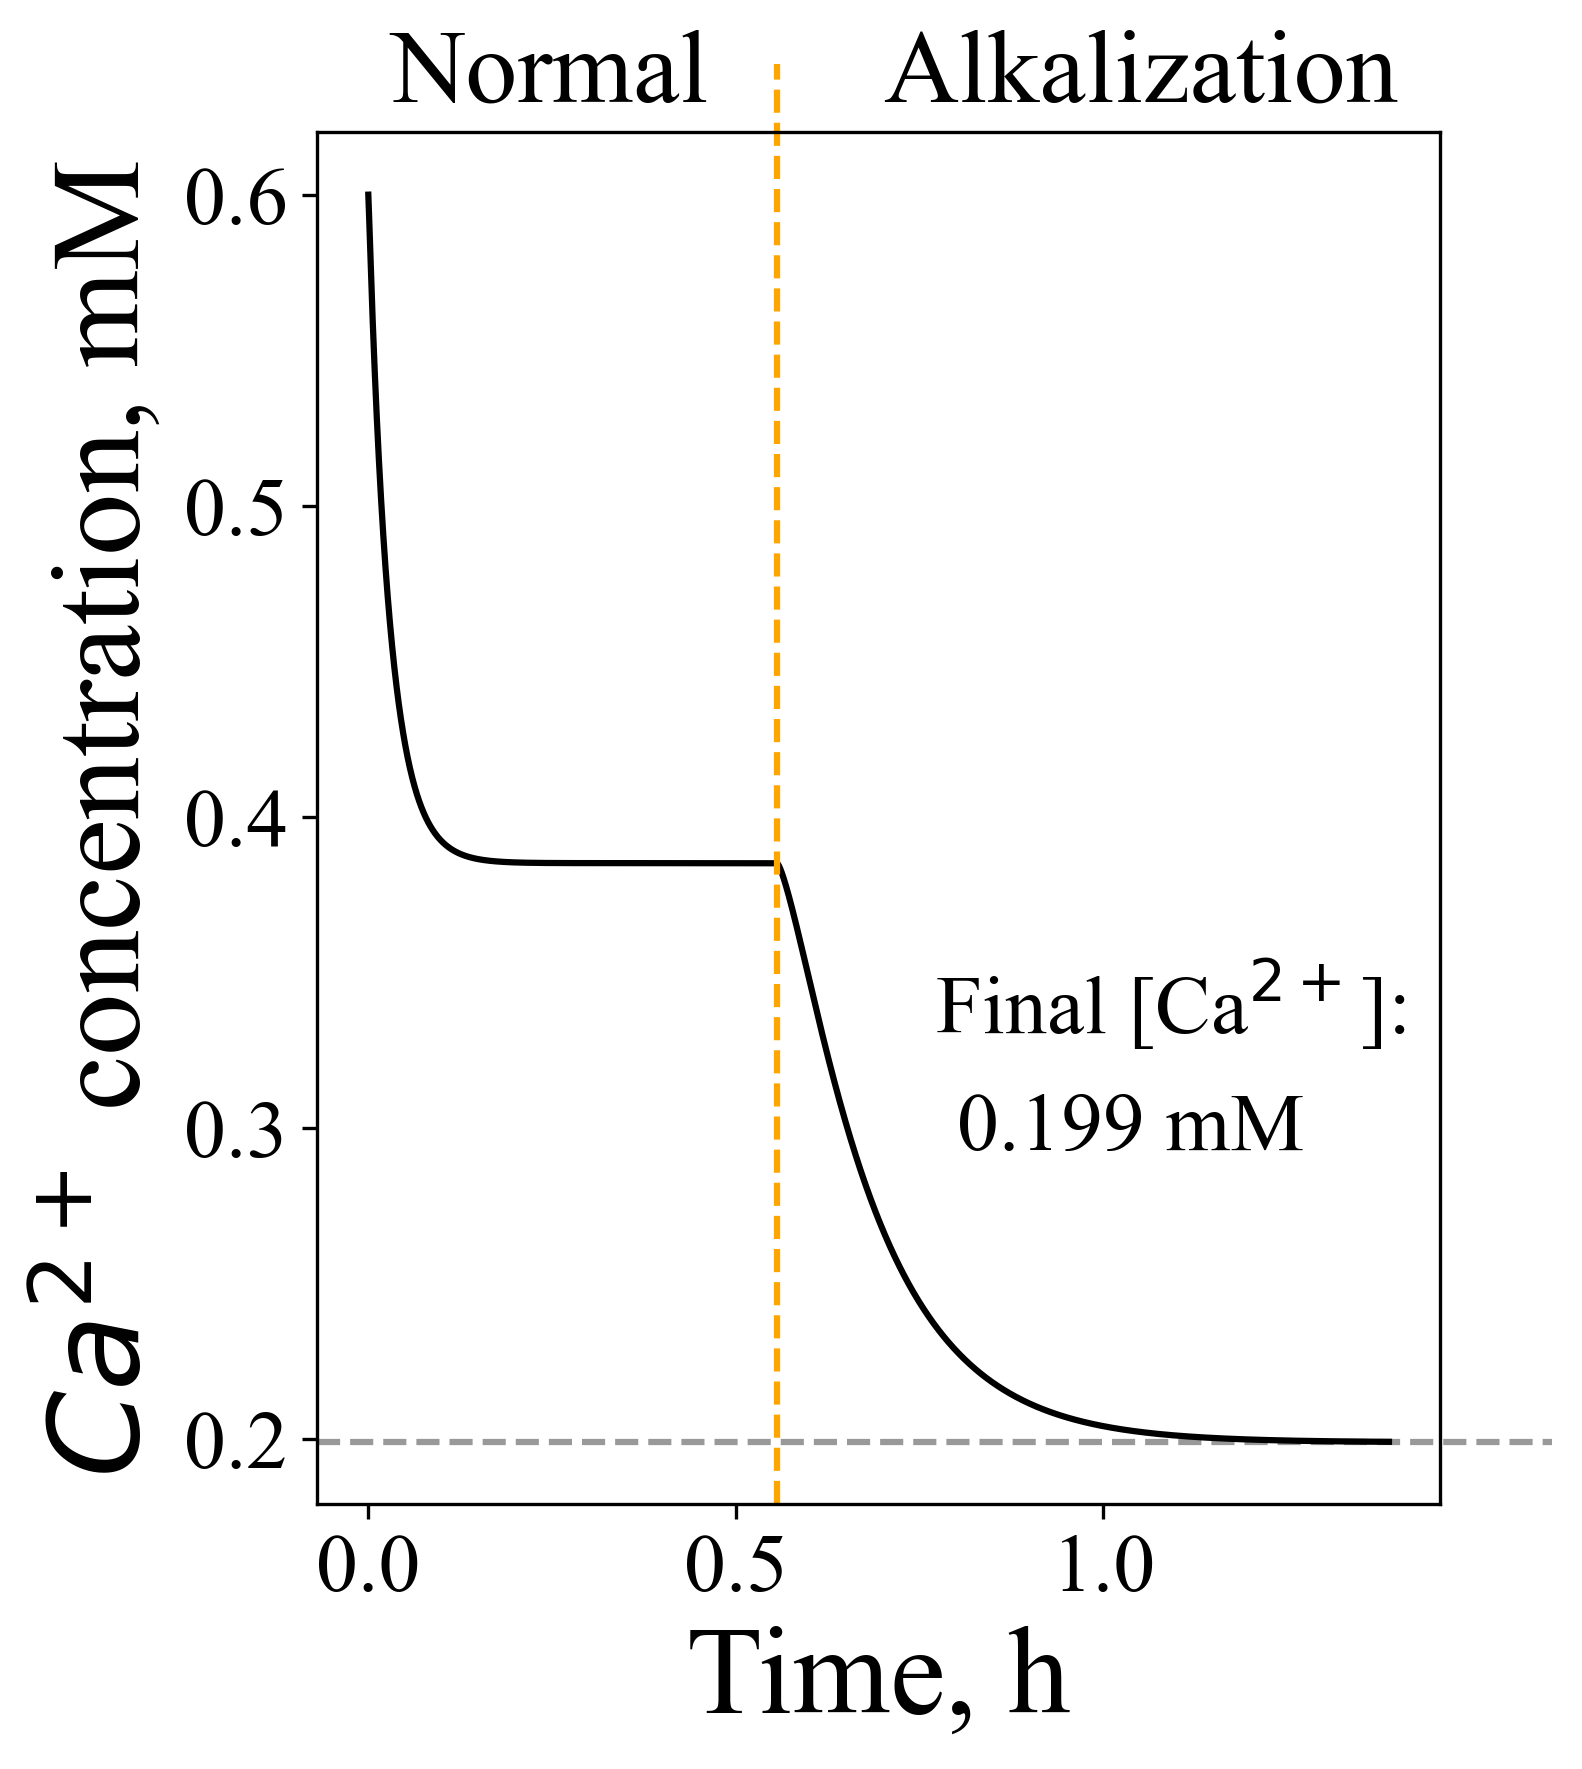

In [16]:
def plot_solution_Ca(t_s, solution, solution_stat, V_arr, V_arr_stat):
    fig, ax = plt.subplots(figsize=(5, 6), dpi=300)

    t = t_s/3600
    ca_conc = solution[:, 7] / V_arr / NA*1000
    ca_stat = solution_stat[:, 7][-1] / V_arr_stat[-1] / NA*1000
    # Plot the concentrations
    ax.plot(t, ca_conc, 'black')
    ax.axhline(ca_stat, 0, 1.1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)

    ax.set_ylabel(r'$Ca^{2+}$ concentration, mM', fontsize=30)
    ax.set_xlabel('Time, h', fontsize=30)
    ax.tick_params(axis='both', labelsize=20)
    # Add a vertical dashed line 
    ax.axvline(2000/3600, 0, 1.05, color = 'orange', clip_on=False, linestyle='dashed', alpha = 1)
    ax.text(0.03, 6.3/10, s='Normal', fontsize=25, color='black')
    ax.text(0.7, 6.3/10, s='Alkalization', fontsize=25, color='black')
    
    ax.text(0.55, 0.4, 'Final [Ca$^{2+}$]:', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')
    ax.text(0.57, 0.3, f'{ca_stat:.3f} mM', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')   
    plt.tight_layout()
    plt.savefig('all_figs/6CAA_CA')
    plt.show()

plot_solution_Ca(tspan, solution, solution_stat, V_arr, V_arr_stat)


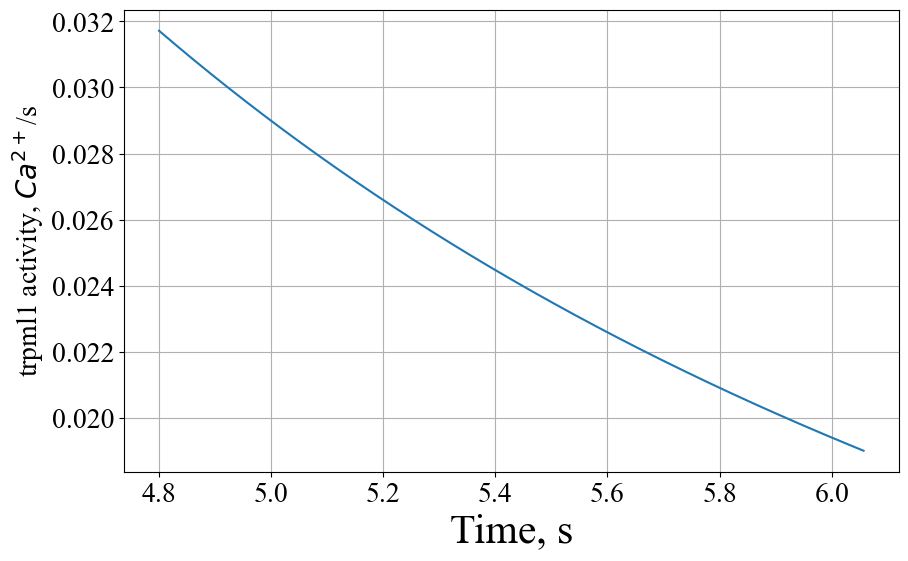

In [193]:
def plot_trpml1_work(t, solution):
    plt.figure(figsize=(10,6), dpi=100)
    S_arr = 4*3.1416*abs(solution[:, 8])**2*1e-8

    psi_arr = (F/cap)*init_V*(solution[:, 1]/V_arr/NA + solution[:, 3]/V_arr/NA + solution[:, 4]/V_arr/NA - solution[:, 5]/V_arr/NA + 2*solution[:, 6]/V_arr/NA - B)
    pH_arr = solution[:, 2]
    Ca_F = solution[:, 6]/V_arr/NA
    Ca_F_C0 = Ca_C*exp(-2*psi_out/RTF) 
    Ca_F_L0 = Ca_F*exp(-2*psi_in/RTF) 
    y = 0.5 - 0.5*np.tanh(psi_arr + 40)
    P_trpml1 = (3.88e-12)*(y*abs(psi_arr) + (1-y)*(abs(psi_arr + 40)**3)/np.power(pH_arr,q)) #change p
    gg_Ca   = 2*psi_arr/(1-exp(-2*psi_arr/RTF))/RTF
    J_Ca_trpml1 = P_trpml1*S_arr*(Ca_F_C0*exp(-2*psi_arr/RTF)-Ca_F_L0)*gg_Ca*NA/1000
    # plt.plot(t, -J_Ca_trpml1, 'b', label='J_v$(t)$')
    plt.plot(pH_arr, (1-y)/np.power(pH_arr, q))
    # plt.legend(loc='best')
    plt.ylabel(r'trpml1 activity, $Ca^{2+}$/s', fontsize=20)
    plt.xlabel('Time, s', fontsize=30)
    plt.grid()
        # Add a vertical dashed line 
    ax.axvline(x=2000, linestyle='--', color='r', alpha=0.5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # plt.xlim(1990,2010)
    plt.show()

plot_trpml1_work(tspan, solution)

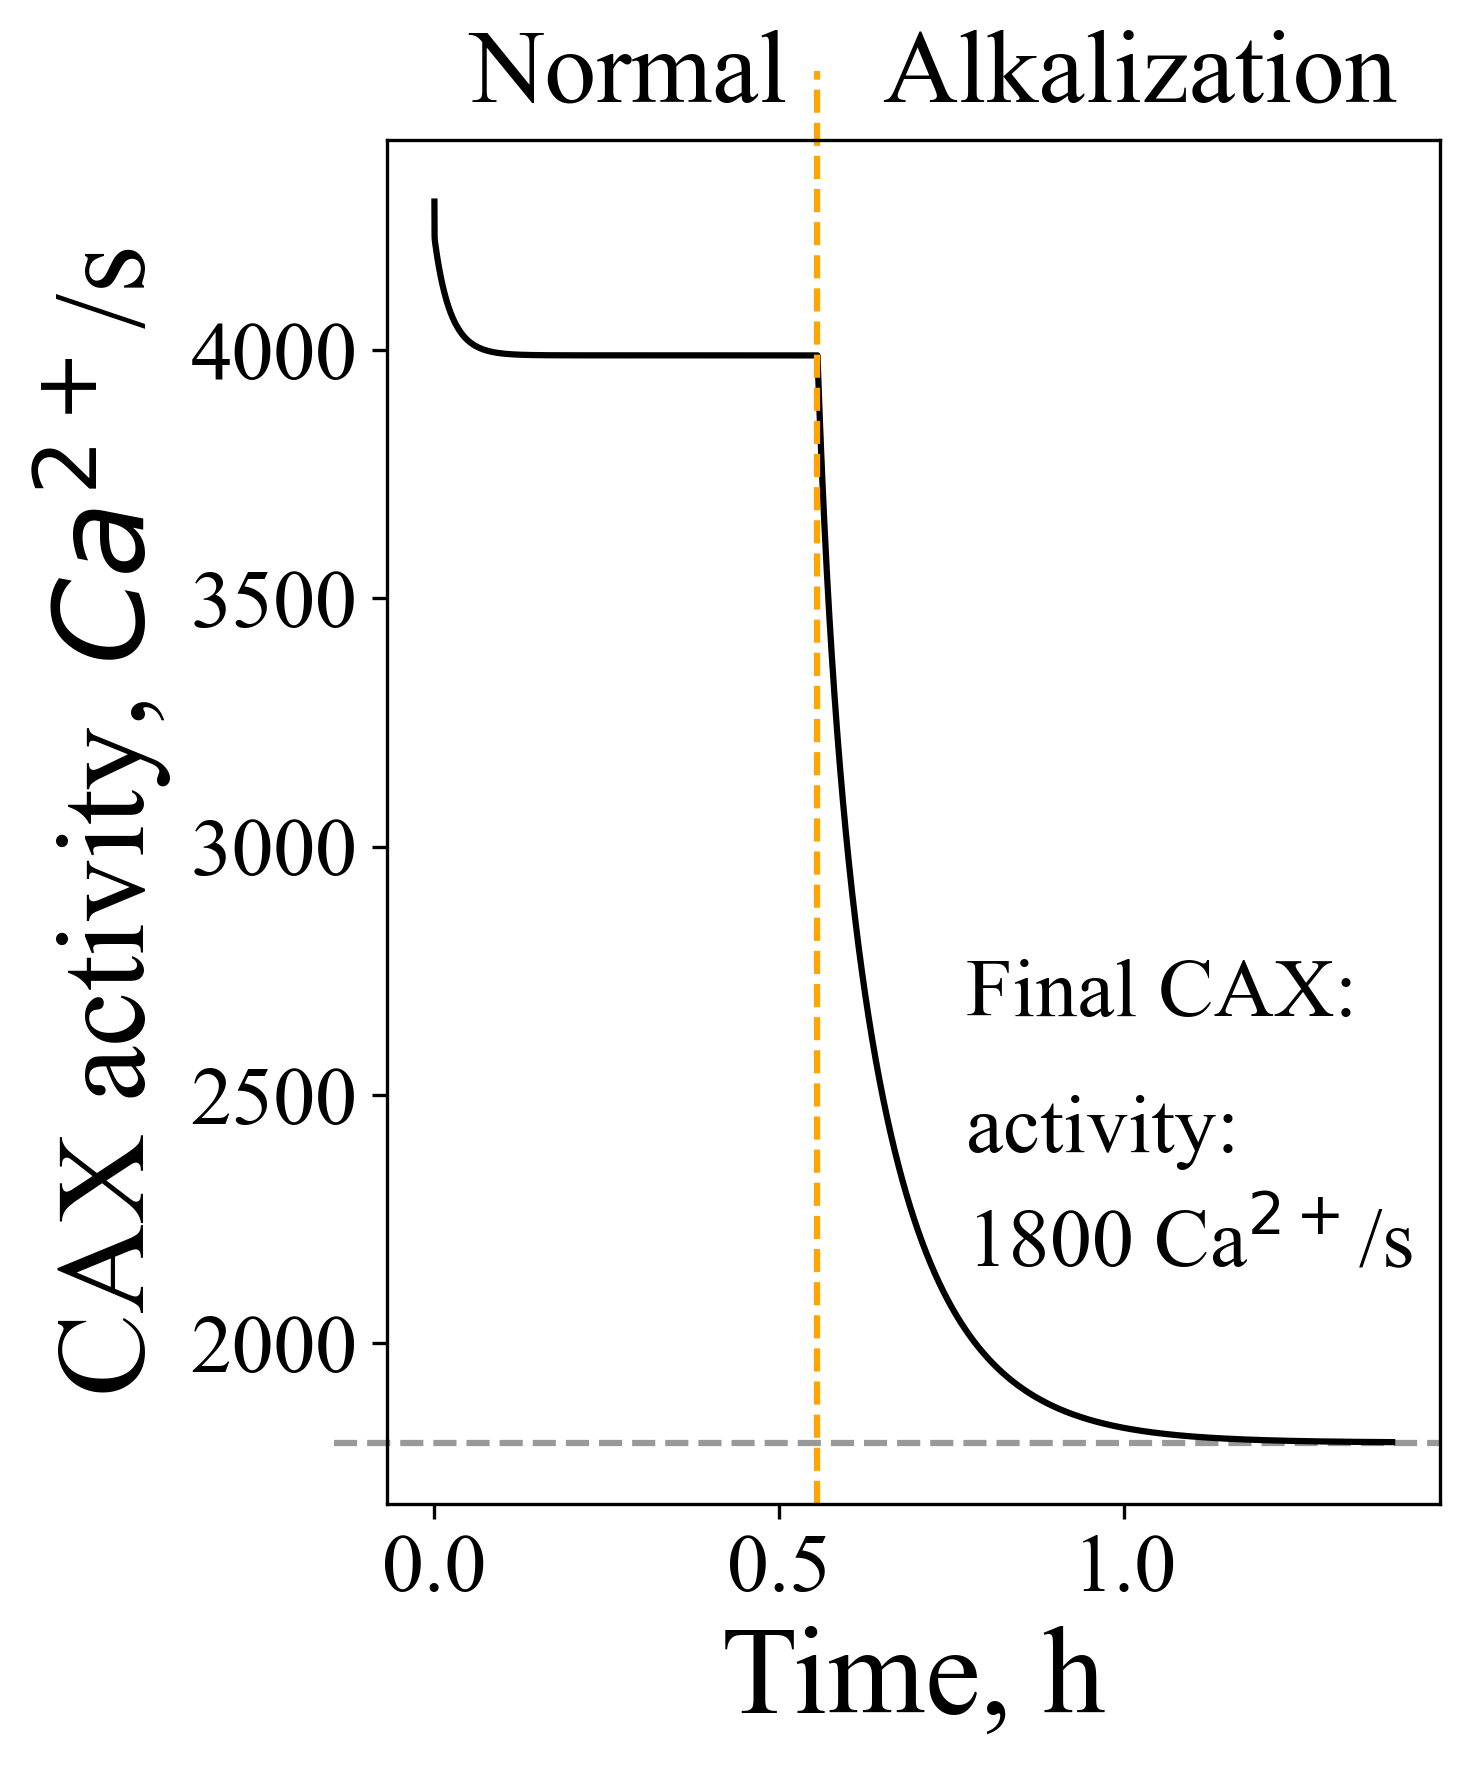

In [18]:


def plot_trpml1_work(t_s, solution, solution_stat, psi_arr, psi_arr_stat, V_arr, V_arr_stat):
    fig, ax = plt.subplots(figsize=(5, 6), dpi=300)
    t = t_s/3600
    pH_arr = solution[:, 2]
    Ca_F = solution[:, 6]/V_arr/NA 
    Ca_F_C0 = Ca_C*exp(-2*psi_out/RTF) 
    Ca_F_L0 = Ca_F*exp(-2*psi_in/RTF) 

    pH_C0   = (pH_C+psi_out/(RTF*2.3))
    pH_L0   = (pH_arr+psi_in/(RTF*2.3))
    delta_pH    = pH_C0-pH_L0
    CAX_mu = (CAX_H - 2*CAX_Ca)*psi_arr + RTF*(CAX_H*2.3*delta_pH + CAX_Ca/2*np.log(Ca_F_L0/Ca_F_C0))
    J_CAX = N_CAX*CAX_mu


    pH_arr_stat = solution_stat[:, 2]
    Ca_F_stat = solution_stat[:, 6]/V_arr_stat/NA
    Ca_F_C0_stat = Ca_C*exp(-2*psi_out/RTF)
    Ca_F_L0_stat = Ca_F_stat*exp(-2*psi_in/RTF)

    pH_C0_stat   = (pH_C+psi_out/(RTF*2.3))
    pH_L0_stat   = (pH_arr_stat+psi_in/(RTF*2.3))
    delta_pH_stat    = pH_C0_stat-pH_L0_stat
    CAX_mu_stat = (CAX_H - 2*CAX_Ca)*psi_arr_stat + RTF*(CAX_H*2.3*delta_pH_stat + CAX_Ca/2*np.log(Ca_F_L0_stat/Ca_F_C0_stat))
    J_CAX_stat = N_CAX*CAX_mu_stat




    ax.plot(t, J_CAX, 'black', label='J_v$(t)$')
    ax.axhline(J_CAX_stat[-1], -0.05, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
    # ax.text(-0.3, J_CAX_stat[-1]*1.1, s=round(J_CAX_stat[-1]), fontsize=20, color='black')
    plt.ylabel(r'CAX activity, $Ca^{2+}$/s', fontsize=30)
    plt.xlabel('Time, h', fontsize=30)
    ax.axvline(2000/3600, 0, 1.05, color = 'orange', clip_on=False, linestyle='dashed', alpha = 1)
    ax.text(0.65, 4500, s='Alkalization', fontsize=25, color='black')
    ax.text(0.05, 4500, s='Normal', fontsize=25, color='black')
    plt.tight_layout()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)


    ax.text(0.55, 0.4, 'Final CAX:', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')
    ax.text(0.55, 0.3, 'activity:', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')
    ax.text(0.55, 0.22, f'{J_CAX_stat[-1]:.0f} Ca$^{{2+}}$/s', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')   
    plt.savefig('all_figs/6CAA_CAX')
    plt.show()



plot_trpml1_work(tspan, solution, solution_stat, psi_arr, psi_arr_stat, V_arr, V_arr_stat)